<a href="https://colab.research.google.com/github/fernandojunior/deteccao-fraude/blob/master/src/Fraud_Detection_Xente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spark load lib

In [1]:
'''!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install pandas_ml
!pip install -q findspark
!pip install catboost
!pip install -U imbalanced-learn
!pip install pyod seaborn catboost plotly_express==0.4.0
!pip install --upgrade pyod
!pip install shap
!pip install --user --upgrade ipywidgets
!jupyter nbextension enable --py widgetsnbextension
#!pip install -r requirements.txt

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"
'''
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('xente').getOrCreate()
spark

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pyspark.sql.functions as F
import shap
import catboost
from catboost import Pool, CatBoostClassifier, cv

from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import mean, udf, array, col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.linalg import Vectors
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                              f1_score, precision_score, recall_score, roc_curve, roc_auc_score)

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
tar: spark-2.4.4-bin-hadoop2.7.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7f7126cd98d0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution')': /simple/imbalanced-learn/
Retrying (Retry(total=3, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7f7126cd9a90>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution')': /simple/imbalanced-learn/
Retrying (Retry(total=2, connect=None, read=None, redi

Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7fa3fa53cb00>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution')': /simple/pyod/
Retrying (Retry(total=3, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7fa3fa53cbe0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution')': /simple/pyod/
Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7fa3fa53c160>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution')': /simple/pyod/
Retrying (Retry(total=1, connect=None, read=None, redirect

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# Load Training Data

In [4]:
def read_data_from_web(url):
  data = pd.read_csv(url)
  spark_data = spark.createDataFrame(data)
  return spark_data

#fraud_data = read_data_from_web("https://drive.google.com/uc?export=download&id=1NrtVkKv8n_g27w5elq9HWZA1i8aFBW0G")
fraud_data = spark.read.csv('training.csv', inferSchema=True, header=True)
df_backup = fraud_data

In [95]:
fraud_data = df_backup

In [96]:
fraud_data.show(5)

+-------------------+--------------+--------------+-------------------+---------------+------------+-----------+------------+------------+------------------+-----------+-------+-----+--------------------+---------------+-----------+
|      TransactionId|       BatchId|     AccountId|     SubscriptionId|     CustomerId|CurrencyCode|CountryCode|  ProviderId|   ProductId|   ProductCategory|  ChannelId| Amount|Value|TransactionStartTime|PricingStrategy|FraudResult|
+-------------------+--------------+--------------+-------------------+---------------+------------+-----------+------------+------------+------------------+-----------+-------+-----+--------------------+---------------+-----------+
|TransactionId_76871| BatchId_36123|AccountId_3957| SubscriptionId_887|CustomerId_4406|         UGX|        256|ProviderId_6|ProductId_10|           airtime|ChannelId_3| 1000.0| 1000| 2018-11-14 21:18:49|              2|          0|
|TransactionId_73770| BatchId_15642|AccountId_4841|SubscriptionId_38

## Data Dictionary

*   **TransactionId:** Unique transaction identifier on platform.
*   **BatchId:** Unique number assigned to a batch of transactions for processing.
*   **AccountId:** Unique number identifying the customer on platform.
*   **SubscriptionId:** Unique number identifying the customer subscription.
*   **CustomerId:** Unique identifier attached to Account.
*   **CurrencyCode:** Country currency.
*   **CountryCode:** Numerical geographical code of country.
*   **ProviderId:** Source provider of Item bought.
*   **ProductId:** Item name being bought.
*   **ProductCategory:** ProductIds are organized into these broader product categories.
*   **ChannelId:** Identifies if customer used web,Android, IOS, pay later or checkout.
*   **Amount:** Value of the transaction. Positive for debits from customer account and negative for credit into customer account.
*   **Value:** Absolute value of the amount.
*   **TransactionStartTime:** Transaction start time.
*   **PricingStrategy:** Category of Xente's pricing structure for merchants.
*   **FraudResult:** Fraud status of transaction: 1) Yes; or 0) No.

In [ ]:
fraud_data.printSchema()

# Data Preprocessing

## Missing Data Analysis

In [7]:
def there_is_missing_data(data):
  return data.count() != data.na.drop(how='any').count()

print('There is missing data? {0}.'.format(there_is_missing_data(fraud_data)))

There is missing data? False.


## Duplicated line?

In [8]:
def there_is_duplicate_lines(data):
  return data.count() != data.distinct().count()

print('There is distinct data? {0}.'.format(there_is_duplicate_lines(fraud_data)))

There is distinct data? False.


## Data Treatment

In [9]:
fraud_data.withColumn('diff', F.abs(fraud_data['Amount'])-F.col('Value')).select('diff').show()

+-------+
|   diff|
+-------+
|    0.0|
|    0.0|
|    0.0|
|-1800.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
+-------+
only showing top 20 rows



It shows the real transaction value. To be precise, we need to categorize the transaction, but first, let us remove unuseful features.

## Removing unuseful features

In [10]:
print('Different CurrencyCode Values: \t\t {0}'.format(fraud_data.select('CurrencyCode').distinct().count()))
print('Different de CountryCode Values: \t {0}'.format(fraud_data.select('CountryCode').distinct().count()))
print('Different de TransactionId Values: \t {0}'.format(fraud_data.select('TransactionId').distinct().count()))

Different CurrencyCode Values: 		 1
Different de CountryCode Values: 	 1
Different de TransactionId Values: 	 95662


CurrencyCode and CountryCode columns have the same value in whole dataset, genuine or fraud.

In [11]:
# data: dataframe - columns: column list to remove
def remove_feature(data, columns_in):
  return data.drop(*columns_in)

In [12]:
def clean_data(fraud_data, columns_to_remove):
  fraud_data = remove_feature(fraud_data, columns_to_remove)
  return fraud_data

In [97]:
#columns_to_remove = ['CurrencyCode','CountryCode','BatchId','AccountId','SubscriptionId','CustomerId', 'TransactionStartTime']
columns_to_remove = ['CurrencyCode','CountryCode','BatchId','SubscriptionId','CustomerId', 'TransactionStartTime']
fraud_data = clean_data(fraud_data, columns_to_remove)

In [98]:
fraud_data.show(5)

+-------------------+--------------+------------+------------+------------------+-----------+-------+-----+---------------+-----------+
|      TransactionId|     AccountId|  ProviderId|   ProductId|   ProductCategory|  ChannelId| Amount|Value|PricingStrategy|FraudResult|
+-------------------+--------------+------------+------------+------------------+-----------+-------+-----+---------------+-----------+
|TransactionId_76871|AccountId_3957|ProviderId_6|ProductId_10|           airtime|ChannelId_3| 1000.0| 1000|              2|          0|
|TransactionId_73770|AccountId_4841|ProviderId_4| ProductId_6|financial_services|ChannelId_2|  -20.0|   20|              2|          0|
|TransactionId_26203|AccountId_4229|ProviderId_6| ProductId_1|           airtime|ChannelId_3|  500.0|  500|              2|          0|
|  TransactionId_380| AccountId_648|ProviderId_1|ProductId_21|      utility_bill|ChannelId_3|20000.0|21800|              2|          0|
|TransactionId_28195|AccountId_4841|ProviderId_4

## Categorizing columns values

In [99]:
fraud_data.printSchema()

root
 |-- TransactionId: string (nullable = true)
 |-- AccountId: string (nullable = true)
 |-- ProviderId: string (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- ProductCategory: string (nullable = true)
 |-- ChannelId: string (nullable = true)
 |-- Amount: double (nullable = true)
 |-- Value: integer (nullable = true)
 |-- PricingStrategy: integer (nullable = true)
 |-- FraudResult: integer (nullable = true)



# Creating and Removing Features

In [100]:
fraud_data = fraud_data.withColumn("Operation", F.when(fraud_data.Amount > 0, 1).when(fraud_data.Amount < 0, -1).otherwise(0))
fraud_data = fraud_data.withColumn('PositiveAmount', F.abs(fraud_data['Amount']))

In [101]:
def get_features_augmentation(fraud_data, clean=False):
  gen_train_data = fraud_data.filter('FraudResult == 0')
  items_list = ['AccountId', 'ChannelId', 'ProductCategory', 'ProductId']

  for item in items_list:
    mean_column_name = 'avg_ps_{0}'.format(item)
    min_column_name = 'min_ps_{0}'.format(item)
    max_column_name = 'max_ps_{0}'.format(item)
    ratio_column_name = 'rt_avg_ps_{0}'.format(item)
    
    mean_aux = gen_train_data.select([item,'PositiveAmount']).groupBy(item).mean()
    mean_aux = mean_aux.select(col(item), col('avg(PositiveAmount)').alias(mean_column_name))
    
    min_aux = gen_train_data.select([item,'PositiveAmount']).groupBy(item).min()    
    min_aux = min_aux.select(col(item), col('min(PositiveAmount)').alias(min_column_name))
    
    max_aux = gen_train_data.select([item,'PositiveAmount']).groupBy(item).max()    
    max_aux = max_aux.select(col(item), col('max(PositiveAmount)').alias(max_column_name))

    fraud_data = fraud_data.join(mean_aux, on=item)
    fraud_data = fraud_data.join(min_aux, on=item)
    fraud_data = fraud_data.join(max_aux, on=item)
    fraud_data = fraud_data.withColumn(ratio_column_name, (F.col('PositiveAmount')-F.col(mean_column_name))/ F.col(mean_column_name))
  
  if clean:
    fraud_data = clean_data(fraud_data)
  
  return fraud_data

In [102]:
fraud_data = get_features_augmentation(fraud_data)
fraud_data = clean_data(fraud_data, columns_to_remove = ['Amount'])

In [103]:
fraud_data.printSchema()

root
 |-- ProductId: string (nullable = true)
 |-- ProductCategory: string (nullable = true)
 |-- ChannelId: string (nullable = true)
 |-- AccountId: string (nullable = true)
 |-- TransactionId: string (nullable = true)
 |-- ProviderId: string (nullable = true)
 |-- Value: integer (nullable = true)
 |-- PricingStrategy: integer (nullable = true)
 |-- FraudResult: integer (nullable = true)
 |-- Operation: integer (nullable = false)
 |-- PositiveAmount: double (nullable = true)
 |-- avg_ps_AccountId: double (nullable = true)
 |-- min_ps_AccountId: double (nullable = true)
 |-- max_ps_AccountId: double (nullable = true)
 |-- rt_avg_ps_AccountId: double (nullable = true)
 |-- avg_ps_ChannelId: double (nullable = true)
 |-- min_ps_ChannelId: double (nullable = true)
 |-- max_ps_ChannelId: double (nullable = true)
 |-- rt_avg_ps_ChannelId: double (nullable = true)
 |-- avg_ps_ProductCategory: double (nullable = true)
 |-- min_ps_ProductCategory: double (nullable = true)
 |-- max_ps_ProductCa

In [104]:
fraud_data.toPandas().head(10)

,ProductId,ProductCategory,ChannelId,AccountId,TransactionId,ProviderId,Value,PricingStrategy,FraudResult,Operation,...,max_ps_ChannelId,rt_avg_ps_ChannelId,avg_ps_ProductCategory,min_ps_ProductCategory,max_ps_ProductCategory,rt_avg_ps_ProductCategory,avg_ps_ProductId,min_ps_ProductId,max_ps_ProductId,rt_avg_ps_ProductId
0,ProductId_10,airtime,ChannelId_3,AccountId_3957,TransactionId_76871,ProviderId_6,1000,2,0,1,...,2400000.0,-0.881630,5867.800373,33.0,2000000.0,-0.829578,7447.448628,300.0,2000000.0,-0.865726
1,ProductId_6,financial_services,ChannelId_2,AccountId_4841,TransactionId_73770,ProviderId_4,20,2,0,-1,...,1000000.0,-0.994786,6504.703021,1.2,2400000.0,-0.996925,903.642597,1.2,25000.0,-0.977867
2,ProductId_1,airtime,ChannelId_3,AccountId_4229,TransactionId_26203,ProviderId_6,500,2,0,1,...,2400000.0,-0.940815,5867.800373,33.0,2000000.0,-0.914789,4202.856499,33.0,300000.0,-0.881033
3,ProductId_21,utility_bill,ChannelId_3,AccountId_648,TransactionId_380,ProviderId_1,21800,2,0,1,...,2400000.0,1.367408,15820.940776,500.0,300000.0,0.264147,12787.171088,500.0,190000.0,0.564068
4,ProductId_6,financial_services,ChannelId_2,AccountId_4841,TransactionId_28195,ProviderId_4,644,2,0,-1,...,1000000.0,-0.832112,6504.703021,1.2,2400000.0,-0.900995,903.642597,1.2,25000.0,-0.287329
5,ProductId_3,airtime,ChannelId_3,AccountId_1078,TransactionId_23223,ProviderId_6,2000,2,0,1,...,2400000.0,-0.763259,5867.800373,33.0,2000000.0,-0.659157,5275.777618,500.0,1000000.0,-0.620909
6,ProductId_3,airtime,ChannelId_3,AccountId_2442,TransactionId_118063,ProviderId_5,10000,4,0,1,...,2400000.0,0.183704,5867.800373,33.0,2000000.0,0.704216,5275.777618,500.0,1000000.0,0.895455
7,ProductId_6,financial_services,ChannelId_2,AccountId_4841,TransactionId_100640,ProviderId_4,500,2,0,-1,...,1000000.0,-0.869652,6504.703021,1.2,2400000.0,-0.923133,903.642597,1.2,25000.0,-0.446684
8,ProductId_10,airtime,ChannelId_3,AccountId_272,TransactionId_51905,ProviderId_6,500,2,0,1,...,2400000.0,-0.940815,5867.800373,33.0,2000000.0,-0.914789,7447.448628,300.0,2000000.0,-0.932863
9,ProductId_15,financial_services,ChannelId_3,AccountId_710,TransactionId_130161,ProviderId_1,600,2,0,1,...,2400000.0,-0.928978,6504.703021,1.2,2400000.0,-0.907759,22047.949860,50.0,2400000.0,-0.972787


# Data Analysis

ProductCategory have a bias to fraud transaction

In [105]:
fraud_data.filter('FraudResult == 0').groupBy('ProductCategory' ).count().show()

+------------------+-----+
|   ProductCategory|count|
+------------------+-----+
|            ticket|  216|
|                tv| 1279|
|             other|    2|
|           airtime|45009|
|         transport|   23|
|      data_bundles| 1613|
|            movies|  175|
|      utility_bill| 1908|
|financial_services|45244|
+------------------+-----+



In [106]:
fraud_data.filter('FraudResult == 1').groupBy('ProductCategory' ).count().show()

+------------------+-----+
|   ProductCategory|count|
+------------------+-----+
|           airtime|   18|
|         transport|    2|
|      utility_bill|   12|
|financial_services|  151|
+------------------+-----+



Counting the number of transactions by category, let us normalize and show in histogram graphic.

Percebe-se que as transações fraudulentas (representadas em azul), incidem principalmente em operações do tipo Serviço financeiro, como também Airtime e Utility_bill.

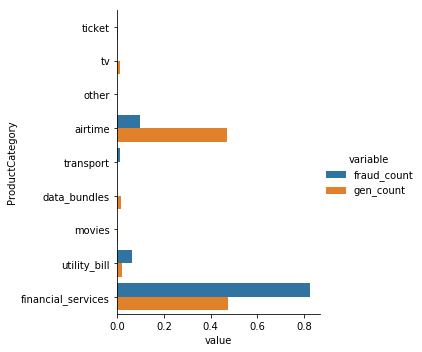

In [24]:
df1 = fraud_data.filter('FraudResult == 0').groupBy('ProductCategory' ).count()
df1 = df1.withColumnRenamed('count', 'gen_count')

df2 = fraud_data.filter('FraudResult == 1').groupBy('ProductCategory' ).count()
df2 = df2.withColumnRenamed('count', 'fraud_count')

new_df = df1.join(df2, on=['ProductCategory'], how='left_outer')
new_df = new_df.fillna({'fraud_count': '0'})

new_df_pd = new_df.toPandas()
new_df_pd['gen_count'] = new_df_pd['gen_count']/sum(new_df_pd['gen_count'])
new_df_pd['fraud_count'] = new_df_pd['fraud_count']/sum(new_df_pd['fraud_count'])
new_df_pd = pd.melt(new_df_pd, id_vars='ProductCategory', value_vars=['fraud_count', 'gen_count'], value_name='value')

sns.catplot(y='ProductCategory', hue='variable', x='value', kind='bar', data=new_df_pd);

Categorizing ProductCategory

In [107]:
indexer = StringIndexer(inputCol = 'ProductCategory', outputCol='ProductCategory_int')
fraud_data = indexer.fit(fraud_data).transform(fraud_data)

# Statistics

## Imbalanced dataset

In [108]:
fraud_data.groupBy("FraudResult").count().show()
outlier_fraction = fraud_data.filter("FraudResult == 1").count() / fraud_data.filter("FraudResult == 0").count()
print('Os dados fraudulentos representam {0:.3f}% dos dados.'.format(outlier_fraction*100))

+-----------+-----+
|FraudResult|count|
+-----------+-----+
|          1|  183|
|          0|95469|
+-----------+-----+

Os dados fraudulentos representam 0.192% dos dados.


## Descriptive analysis of numerical variables

### Value descriptions

In [109]:
fraud_data.printSchema()

root
 |-- ProductId: string (nullable = true)
 |-- ProductCategory: string (nullable = true)
 |-- ChannelId: string (nullable = true)
 |-- AccountId: string (nullable = true)
 |-- TransactionId: string (nullable = true)
 |-- ProviderId: string (nullable = true)
 |-- Value: integer (nullable = true)
 |-- PricingStrategy: integer (nullable = true)
 |-- FraudResult: integer (nullable = true)
 |-- Operation: integer (nullable = false)
 |-- PositiveAmount: double (nullable = true)
 |-- avg_ps_AccountId: double (nullable = true)
 |-- min_ps_AccountId: double (nullable = true)
 |-- max_ps_AccountId: double (nullable = true)
 |-- rt_avg_ps_AccountId: double (nullable = true)
 |-- avg_ps_ChannelId: double (nullable = true)
 |-- min_ps_ChannelId: double (nullable = true)
 |-- max_ps_ChannelId: double (nullable = true)
 |-- rt_avg_ps_ChannelId: double (nullable = true)
 |-- avg_ps_ProductCategory: double (nullable = true)
 |-- min_ps_ProductCategory: double (nullable = true)
 |-- max_ps_ProductCa

In [184]:
all_features = ['ProductId','ProductCategory','PricingStrategy','ChannelId','ProviderId',
                            'AccountId','TransactionId','Value','Operation', 'PositiveAmount','ProductCategory_int',
                            'avg_ps_AccountId','min_ps_AccountId','max_ps_AccountId','rt_avg_ps_AccountId',
                            'avg_ps_ChannelId','min_ps_ChannelId','max_ps_ChannelId','rt_avg_ps_ChannelId',
                            'avg_ps_ProductCategory','min_ps_ProductCategory','max_ps_ProductCategory','rt_avg_ps_ProductCategory',
                            'avg_ps_ProductId','min_ps_ProductId','max_ps_ProductId','rt_avg_ps_ProductId']

numerical_features = ['Value', 'PricingStrategy', 'Operation', 'PositiveAmount', 'ProductCategory_int',
                                        'avg_ps_AccountId','min_ps_AccountId','max_ps_AccountId','rt_avg_ps_AccountId',
                                        'avg_ps_ChannelId','min_ps_ChannelId','max_ps_ChannelId','rt_avg_ps_ChannelId',
                                        'avg_ps_ProductCategory','min_ps_ProductCategory','max_ps_ProductCategory','rt_avg_ps_ProductCategory',
                                        'avg_ps_ProductId','min_ps_ProductId','max_ps_ProductId','rt_avg_ps_ProductId']

categorical_features = ['ProductId','ProductCategory','PricingStrategy','ChannelId','ProviderId','AccountId','TransactionId']

label = 'FraudResult'

In [111]:
print('Fraud data set')
fraud_data.select(numerical_features).filter(fraud_data['FraudResult'] == 1).toPandas().describe()

Fraud data set


,Value,PricingStrategy,Operation,PositiveAmount,ProductCategory_int,avg_ps_AccountId,min_ps_AccountId,max_ps_AccountId,rt_avg_ps_AccountId,avg_ps_ChannelId,...,max_ps_ChannelId,rt_avg_ps_ChannelId,avg_ps_ProductCategory,min_ps_ProductCategory,max_ps_ProductCategory,rt_avg_ps_ProductCategory,avg_ps_ProductId,min_ps_ProductId,max_ps_ProductId,rt_avg_ps_ProductId
count,1.830000e+02,183.000000,183.000000,1.830000e+02,183.000000,1.830000e+02,1.830000e+02,1.830000e+02,183.000000,183.000000,...,1.830000e+02,183.000000,183.000000,183.000000,1.830000e+02,183.000000,183.000000,183.000000,1.830000e+02,183.000000
mean,1.594159e+06,1.699454,0.945355,1.592402e+06,0.306011,1.471015e+05,4.637378e+04,1.134387e+06,71.223701,8737.143380,...,2.317180e+06,188.102625,7968.325636,321.175956,2.201617e+06,239.541233,21425.082507,478.968306,2.086415e+06,76.463984
std,2.128883e+06,0.979095,0.326937,2.129723e+06,0.898299,1.881461e+05,1.951798e+05,9.525980e+05,295.669198,2902.893289,...,3.719186e+05,252.249066,8983.189100,2709.509747,5.557814e+05,329.562618,9347.222231,2734.773385,6.940725e+05,95.960574
min,5.000000e+02,0.000000,-1.000000,5.000000e+02,0.000000,5.000000e+02,1.200000e+00,5.000000e+02,-0.989930,3835.880507,...,3.610000e+05,-0.940815,5867.800373,1.200000,3.000000e+05,-0.914789,903.642597,1.200000,2.500000e+04,-0.905227
25%,5.000000e+05,2.000000,1.000000,5.000000e+05,0.000000,4.637500e+04,5.000000e+02,2.000000e+05,2.806878,8448.058854,...,2.400000e+06,58.185194,6504.703021,1.200000,2.400000e+06,75.867460,22047.949860,50.000000,2.400000e+06,21.677845
50%,6.293740e+05,2.000000,1.000000,6.000000e+05,0.000000,1.237500e+05,1.000000e+03,1.000000e+06,7.993850,8448.058854,...,2.400000e+06,70.022232,6504.703021,1.200000,2.400000e+06,91.240952,22047.949860,50.000000,2.400000e+06,33.923882
75%,2.000000e+06,2.000000,1.000000,2.000000e+06,0.000000,1.848816e+05,5.000000e+03,2.000000e+06,18.745189,8448.058854,...,2.400000e+06,235.740775,6504.703021,1.200000,2.400000e+06,306.469840,22047.949860,50.000000,2.400000e+06,93.772759
max,9.880000e+06,4.000000,1.000000,9.880000e+06,7.000000,1.095860e+06,1.095860e+06,2.400000e+06,3319.000000,27438.898876,...,2.400000e+06,1168.499428,90260.869565,26000.000000,2.400000e+06,1517.901012,90260.869565,26000.000000,2.400000e+06,447.114227


In [112]:
print('Genuine data set')
fraud_data.select(numerical_features).filter(fraud_data['FraudResult'] == 0).toPandas().describe()

Genuine data set


,Value,PricingStrategy,Operation,PositiveAmount,ProductCategory_int,avg_ps_AccountId,min_ps_AccountId,max_ps_AccountId,rt_avg_ps_AccountId,avg_ps_ChannelId,...,max_ps_ChannelId,rt_avg_ps_ChannelId,avg_ps_ProductCategory,min_ps_ProductCategory,max_ps_ProductCategory,rt_avg_ps_ProductCategory,avg_ps_ProductId,min_ps_ProductId,max_ps_ProductId,rt_avg_ps_ProductId
count,9.546900e+04,95469.000000,95469.000000,9.546900e+04,95469.000000,9.546900e+04,9.546900e+04,9.546900e+04,9.546900e+04,95469.000000,...,9.546900e+04,9.546900e+04,95469.000000,95469.000000,9.546900e+04,9.546900e+04,95469.000000,95469.000000,9.546900e+04,9.546900e+04
mean,6.763227e+03,2.257089,0.200075,6.723033e+03,0.639862,6.723033e+03,1.008746e+03,1.060897e+05,-1.023755e-15,6723.033294,...,1.818933e+06,-7.977032e-15,6723.033294,54.946525,2.096122e+06,-1.734951e-15,6723.033294,295.499123,9.052610e+05,-1.527620e-15
std,3.999484e+04,0.731971,0.979786,3.995819e+04,0.802551,2.037517e+04,1.176793e+04,2.837309e+05,1.950106e+00,2728.030478,...,7.108775e+05,5.009198e+00,4884.014959,425.977707,4.760395e+05,6.112775e+00,8964.072329,1217.212028,8.931856e+05,3.007323e+00
min,2.000000e+00,0.000000,-1.000000,1.200000e+00,0.000000,1.000000e+02,1.200000e+00,1.000000e+02,-9.990031e-01,3835.880507,...,1.150000e+05,-9.996872e-01,500.000000,1.200000,5.000000e+02,-9.998155e-01,500.000000,1.200000,5.000000e+02,-9.986720e-01
25%,2.500000e+02,2.000000,-1.000000,2.500000e+02,0.000000,8.982737e+02,1.200000e+00,1.400000e+04,-8.886754e-01,3835.880507,...,1.000000e+06,-9.408148e-01,5867.800373,1.200000,2.000000e+06,-9.615663e-01,903.642597,1.200000,2.500000e+04,-9.052272e-01
50%,1.000000e+03,2.000000,1.000000,1.000000e+03,1.000000,2.601754e+03,5.000000e+02,2.500000e+04,-5.833031e-01,8448.058854,...,2.400000e+06,-8.816296e-01,6504.703021,33.000000,2.000000e+06,-8.295784e-01,5275.777618,50.000000,1.000000e+06,-7.786736e-01
75%,5.000000e+03,2.000000,1.000000,5.000000e+03,1.000000,6.200000e+03,5.000000e+02,5.000000e+04,1.055823e-02,8448.058854,...,2.400000e+06,-1.203787e-02,6504.703021,33.000000,2.400000e+06,-2.313254e-01,7447.448628,500.000000,2.000000e+06,-1.382419e-01
max,2.400000e+06,4.000000,1.000000,2.400000e+06,8.000000,2.000000e+06,2.000000e+06,2.400000e+06,2.017297e+02,27438.898876,...,2.400000e+06,2.830889e+02,96696.759259,26000.000000,2.400000e+06,3.679638e+02,138383.720930,33000.000000,2.400000e+06,2.675483e+02


In [49]:
mean_value = fraud_data.select(mean(fraud_data['value'])).collect()[0][0]

print('Mean Value of transactions US$ {0:.2f}'.format(mean_value))

Mean Value of transactions US$ 9800.21


In [50]:
percentFraudByAvgValueLow = fraud_data.filter("FraudResult == 1 and PositiveAmount < " + str(mean_value) ).count() / fraud_data.filter('FraudResult == 1').count()
percentGenByAvgValueLow = fraud_data.filter("FraudResult == 0 and PositiveAmount < "+ str(mean_value) ).count() / fraud_data.filter('FraudResult == 0').count()

percentFraudByAvgValueHigh = fraud_data.filter("FraudResult == 1 and PositiveAmount > "+ str(mean_value) ).count() / fraud_data.filter('FraudResult == 1').count()
percentGenByAvgValueHigh = fraud_data.filter("FraudResult == 0 and PositiveAmount > "+ str(mean_value) ).count() / fraud_data.filter('FraudResult == 0').count()


print('Fraud Transactions under average value: \t{0:.2f}%.'.format(percentFraudByAvgValueLow * 100))
print('Fraud Transactions over average value: \t{0:.2f}%.\n'.format(percentFraudByAvgValueHigh * 100))

print('Genuine Transactions under average value: \t{0:.2f}%.'.format(percentGenByAvgValueLow * 100))
print('Genuine Transactions over average value: \t\t{0:.2f}%.'.format(percentGenByAvgValueHigh * 100))

Fraud Transactions under average value: 	1.09%.
Fraud Transactions over average value: 	98.91%.

Genuine Transactions under average value: 	80.60%.
Genuine Transactions over average value: 		19.40%.


Under average value of dataset
- 1% : Fraud transactions
- 80% : Genuine transactions

Considerations:
- Most transactions are below average, ie there is a general consumption pattern, where there are many transactions costing little, and few transactions costing a lot, justifying why you pulled the average value up. 
- This bias in transaction values is greater when referring to fraudulent transactions.

In [51]:
mean_val_fraud = fraud_data.filter("FraudResult == 1").select(mean(fraud_data['value'])).collect()[0][0]
mean_val_notfraud = fraud_data.filter("FraudResult == 0").select(mean(fraud_data['value'])).collect()[0][0]

print('Average Value of a fraud transaction: \t\tUS$ {0:.2f}.'.format(mean_val_fraud))
print('Average Value of a genuine transaction: \tUS$ {0:.2f}.'.format(mean_val_notfraud))

Average Value of a fraud transaction: 		US$ 1594159.47.
Average Value of a genuine transaction: 	US$ 6763.23.


In [52]:
percentFraud2ByAvgValue = fraud_data.filter("FraudResult == 1 and PositiveAmount > "+ str(mean_val_fraud) ).count() / fraud_data.filter('FraudResult == 1').count()
percentGen2ByAvgValue = fraud_data.filter("FraudResult == 0 and PositiveAmount > "+ str(mean_val_notfraud) ).count() / fraud_data.filter('FraudResult == 0').count()

print('Mount of fraud transaction over the average: \t\t{0:.1f}%'.format(percentFraud2ByAvgValue * 100))
print('Mount of genuine transaction over the average: \t{0:.1f}%'.format(percentGen2ByAvgValue * 100))

Mount of fraud transaction over the average: 		27.9%
Mount of genuine transaction over the average: 	20.4%


In [53]:
percentFraudByOperation = fraud_data.filter("FraudResult == 1 and Operation == 1 ").count() / fraud_data.filter('FraudResult == 1').count()
percentGenByOperation = fraud_data.filter("FraudResult == 0 and Operation == 1 ").count() / fraud_data.filter('FraudResult == 0').count()

print('Debit Fraud Transaction:  {0:.1f}%.'.format(percentFraudByOperation * 100))
print('Credit Fraud Transaction: {0:.1f}%.\n'.format(100-(percentFraudByOperation * 100)))

print('Debit Genuine Transaction:  {0:.1f}%.'.format(percentGenByOperation * 100))
print('Credit Genuine Transaction: {0:.1f}%.'.format(100-(percentGenByOperation * 100)))

Debit Fraud Transaction:  97.3%.
Credit Fraud Transaction: 2.7%.

Debit Genuine Transaction:  60.0%.
Credit Genuine Transaction: 40.0%.


- 25% of Genuine Transactions are credit
- 75% of Fraud Transactions are debit
- Average Value of a Genuine Transaction is $6,763.00 (mean: $1,000.00)
- Average Value of a Fraud Transaction is $1,561,820.00 (mean: $650,000.00).
- FraudAverageValue*4 = GenuineAverageValue

### Product - Channel | descriptives

In [54]:
fraud_data.filter('FraudResult == 1').stat.crosstab("ChannelId","ProductId").show()

+-------------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+
|ChannelId_ProductId|ProductId_10|ProductId_13|ProductId_15|ProductId_21|ProductId_22|ProductId_3|ProductId_5|ProductId_6|ProductId_9|
+-------------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+
|        ChannelId_1|           0|           0|           1|           0|           0|          0|          0|          0|          3|
|        ChannelId_3|           5|           6|         146|           4|           2|          9|          2|          0|          0|
|        ChannelId_2|           1|           0|           0|           0|           0|          3|          0|          1|          0|
+-------------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+



In [55]:
fraud_data.filter('FraudResult == 0').stat.crosstab("ChannelId","ProductId").show()

+-------------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|ChannelId_ProductId|ProductId_1|ProductId_10|ProductId_11|ProductId_12|ProductId_13|ProductId_14|ProductId_15|ProductId_16|ProductId_19|ProductId_2|ProductId_20|ProductId_21|ProductId_22|ProductId_23|ProductId_24|ProductId_27|ProductId_3|ProductId_4|ProductId_5|ProductId_6|ProductId_7|ProductId_8|ProductId_9|
+-------------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|        ChannelId_1|         13|          95|          17|     

- CHANNEL 3: onde ocorrem fraudes.
- CHANNEL 3: onde ocorrem mais transacoes genuinas.
- PRODUCT 3: produtos com maior indice busca de compra.
- PRODUCT 15: produtos com maior indice de fraude.
- CHANNEL 2: O PRODUCT 3 eh mais buscao neste canal.

### Histogram plotting

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f98be289e80>,
      dtype=object)

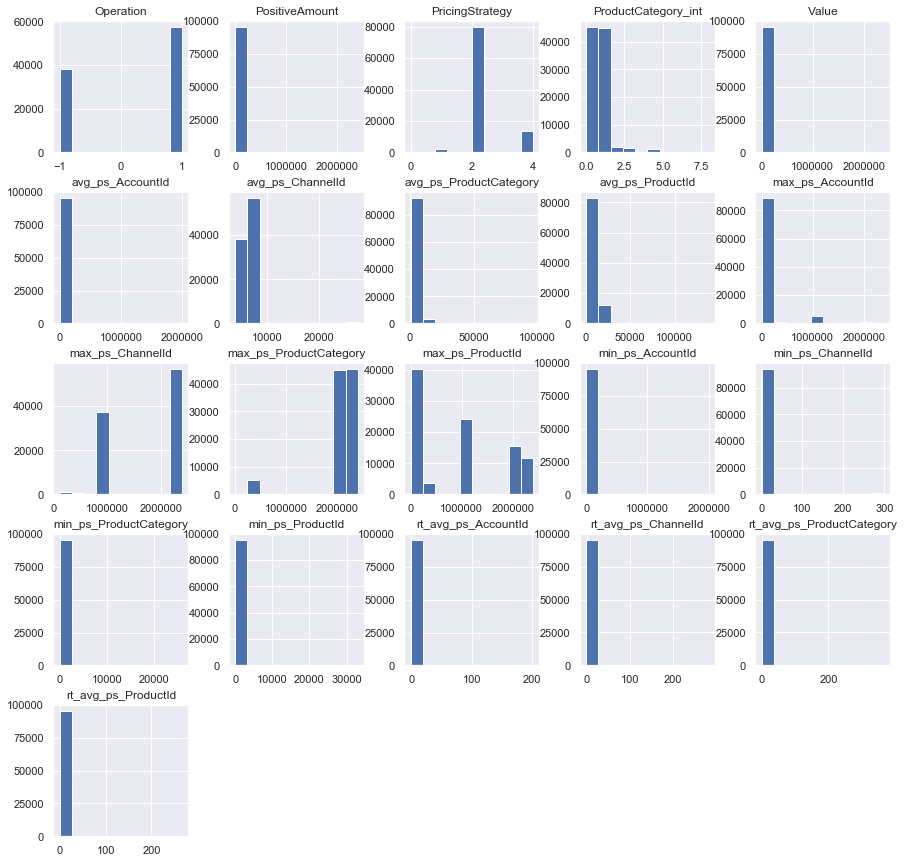

In [113]:
fraud_data.filter('Fraudresult == 0').toPandas().hist(column=numerical_features, figsize=(15,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f98eccb1f98>,
      dtype=object)

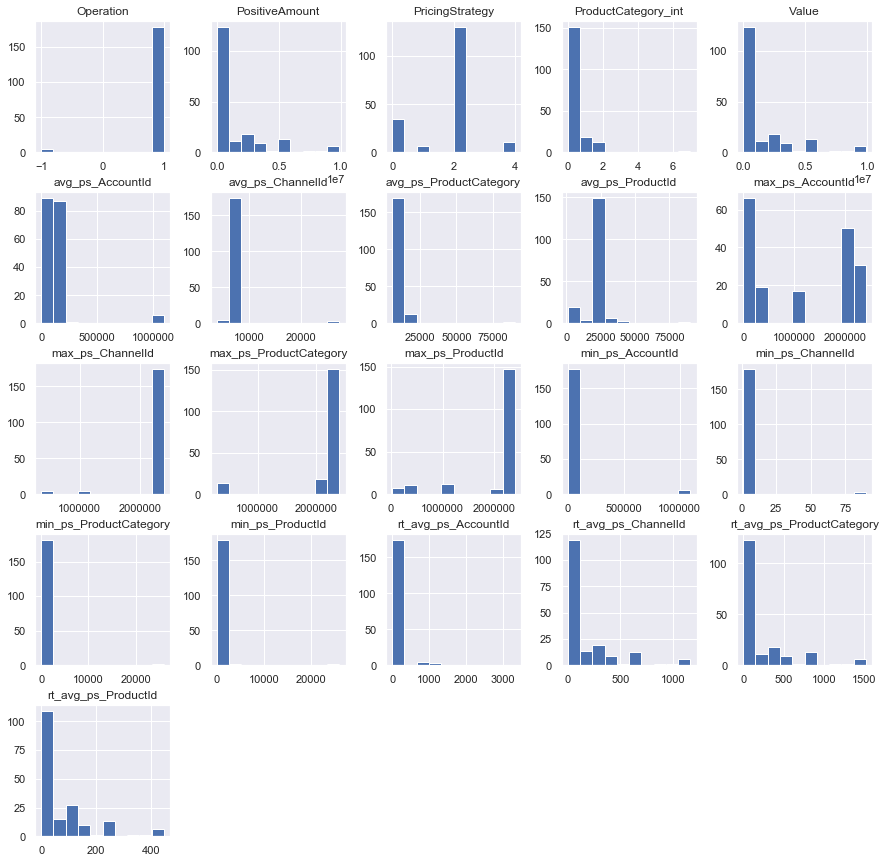

In [114]:
fraud_data.filter('FraudResult == 1').toPandas().hist(column=numerical_features, figsize=(15,15))

## Correlation

In [115]:
corr = []
def plot_heatmap(data, method):
  global corr 
  corr = data.corr(method)
  ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
  )
  ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

### Fraud data

,Value,PricingStrategy,Operation,PositiveAmount,ProductCategory_int,avg_ps_AccountId,min_ps_AccountId,max_ps_AccountId,rt_avg_ps_AccountId,avg_ps_ChannelId,...,max_ps_ChannelId,rt_avg_ps_ChannelId,avg_ps_ProductCategory,min_ps_ProductCategory,max_ps_ProductCategory,rt_avg_ps_ProductCategory,avg_ps_ProductId,min_ps_ProductId,max_ps_ProductId,rt_avg_ps_ProductId
Value,1.000000,-0.169240,0.131180,0.997215,-0.243971,0.403466,-0.054213,0.379112,0.591520,0.092480,...,0.101160,0.951585,0.194439,-0.243971,0.245279,0.921249,0.266251,-0.195491,0.240190,0.811985
PricingStrategy,-0.169240,1.000000,-0.158950,-0.153024,0.186465,-0.124016,-0.065837,-0.069166,0.042141,-0.080961,...,-0.155418,-0.139519,-0.269340,0.186465,-0.183918,-0.088350,-0.143507,0.207754,-0.194361,-0.043354
Operation,0.131180,-0.158950,1.000000,0.127634,-0.247650,0.225536,0.234038,0.052228,-0.074894,0.753638,...,0.719767,-0.032652,0.314842,-0.247650,0.247650,0.051272,0.384133,-0.168889,0.321940,-0.061140
PositiveAmount,0.997215,-0.153024,0.127634,1.000000,-0.270746,0.403997,-0.072946,0.386366,0.596592,0.090326,...,0.098060,0.954999,0.161926,-0.270746,0.272881,0.932752,0.280475,-0.217768,0.267799,0.807409
ProductCategory_int,-0.243971,0.186465,-0.247650,-0.270746,1.000000,-0.326579,-0.156906,-0.230562,0.044626,-0.227592,...,-0.134996,-0.200990,-0.029158,1.000000,-0.999247,-0.372512,-0.286381,0.936553,-0.917398,-0.044567
avg_ps_AccountId,0.403466,-0.124016,0.225536,0.403997,-0.326579,1.000000,0.198749,0.839146,-0.361835,0.047165,...,0.292040,0.400793,-0.000431,-0.326579,0.323415,0.443928,0.017584,-0.349026,0.384448,0.384334
min_ps_AccountId,-0.054213,-0.065837,0.234038,-0.072946,-0.156906,0.198749,1.000000,-0.153773,-0.290967,0.098930,...,0.250253,-0.069047,0.220878,-0.156906,0.150427,-0.107780,0.068854,-0.198534,0.223122,-0.093875
max_ps_AccountId,0.379112,-0.069166,0.052228,0.386366,-0.230562,0.839146,-0.153773,1.000000,-0.220521,-0.087227,...,0.171291,0.416098,-0.134630,-0.230562,0.227823,0.451564,-0.064889,-0.249628,0.293598,0.412520
rt_avg_ps_AccountId,0.591520,0.042141,-0.074894,0.596592,0.044626,-0.361835,-0.290967,-0.220521,1.000000,0.054127,...,-0.170688,0.581583,0.075578,0.044626,-0.039915,0.545840,0.175785,0.118221,-0.061251,0.522152
avg_ps_ChannelId,0.092480,-0.080961,0.753638,0.090326,-0.227592,0.047165,0.098930,-0.087227,0.054127,1.000000,...,0.086142,-0.164400,0.237719,-0.227592,0.227592,0.041531,0.463520,0.009034,0.094518,-0.172990


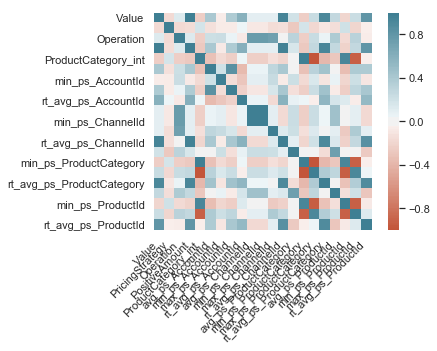

In [116]:
plot_heatmap(fraud_data.filter('FraudResult == 1').select(numerical_features).toPandas(), 'spearman')
corr

,Value,PricingStrategy,Operation,PositiveAmount,ProductCategory_int,avg_ps_AccountId,min_ps_AccountId,max_ps_AccountId,rt_avg_ps_AccountId,avg_ps_ChannelId,...,max_ps_ChannelId,rt_avg_ps_ChannelId,avg_ps_ProductCategory,min_ps_ProductCategory,max_ps_ProductCategory,rt_avg_ps_ProductCategory,avg_ps_ProductId,min_ps_ProductId,max_ps_ProductId,rt_avg_ps_ProductId
Value,1.000000,-0.076441,0.087939,0.999995,-0.148340,0.736420,0.707508,0.195288,0.003949,-0.037381,...,0.104579,0.997990,-0.052889,-0.031333,0.164912,0.997593,0.068655,-0.049713,0.215185,0.977124
PricingStrategy,-0.076441,1.000000,-0.188907,-0.076357,0.142627,-0.037913,0.054511,-0.123027,0.040233,-0.004928,...,-0.153228,-0.066699,0.014823,0.032338,-0.068772,-0.073078,-0.161325,0.051389,-0.231501,0.012018
Operation,0.087939,-0.188907,1.000000,0.087766,-0.092419,0.113559,0.039586,0.058111,0.029897,0.283754,...,0.595199,0.042584,0.036914,0.018269,0.036775,0.080933,0.298272,0.007296,0.261850,-0.014384
PositiveAmount,0.999995,-0.076357,0.087766,1.000000,-0.149846,0.736527,0.707368,0.196025,0.004110,-0.037284,...,0.104353,0.997997,-0.053594,-0.031375,0.167686,0.997714,0.068444,-0.050072,0.217288,0.977181
ProductCategory_int,-0.148340,0.142627,-0.092419,-0.149846,1.000000,-0.173904,-0.061680,-0.280673,0.411567,-0.072983,...,-0.015823,-0.142300,0.887029,0.809537,-0.812399,-0.204847,0.465530,0.856564,-0.709829,-0.132189
avg_ps_AccountId,0.736420,-0.037913,0.113559,0.736527,-0.173904,1.000000,0.920973,0.307857,-0.163250,-0.062527,...,0.146992,0.734352,-0.102726,-0.082652,0.170380,0.739427,-0.004571,-0.103918,0.235620,0.718627
min_ps_AccountId,0.707508,0.054511,0.039586,0.707368,-0.061680,0.920973,1.000000,-0.057488,-0.049990,-0.022591,...,0.051907,0.706355,-0.033031,-0.026801,0.058945,0.705134,0.000928,-0.035389,0.081554,0.702713
max_ps_AccountId,0.195288,-0.123027,0.058111,0.196025,-0.280673,0.307857,-0.057488,1.000000,-0.241601,-0.133618,...,0.160382,0.199899,-0.181145,-0.132319,0.313584,0.210051,-0.047176,-0.163509,0.381089,0.180428
rt_avg_ps_AccountId,0.003949,0.040233,0.029897,0.004110,0.411567,-0.163250,-0.049990,-0.241601,1.000000,-0.013404,...,0.036136,0.003718,0.542459,0.568184,-0.144481,-0.037556,0.467061,0.554767,-0.083910,-0.043232
avg_ps_ChannelId,-0.037381,-0.004928,0.283754,-0.037284,-0.072983,-0.062527,-0.022591,-0.133618,-0.013404,1.000000,...,-0.601659,-0.082135,-0.013839,-0.012235,0.060873,-0.036805,0.296216,-0.002914,-0.183824,-0.091305


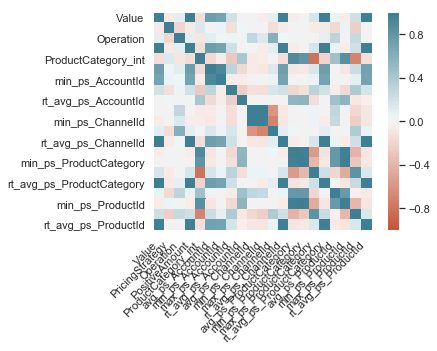

In [117]:
plot_heatmap(fraud_data.filter('FraudResult == 1').select(numerical_features).toPandas(), 'pearson')
corr

### Genuine data

,Value,PricingStrategy,Operation,PositiveAmount,ProductCategory_int,avg_ps_AccountId,min_ps_AccountId,max_ps_AccountId,rt_avg_ps_AccountId,avg_ps_ChannelId,...,max_ps_ChannelId,rt_avg_ps_ChannelId,avg_ps_ProductCategory,min_ps_ProductCategory,max_ps_ProductCategory,rt_avg_ps_ProductCategory,avg_ps_ProductId,min_ps_ProductId,max_ps_ProductId,rt_avg_ps_ProductId
Value,1.000000,0.220980,0.465563,0.999659,0.397674,0.728425,0.628247,0.129355,0.853724,0.472159,...,0.441072,0.978353,-0.225025,0.398223,-0.397253,0.988568,0.656286,0.482473,0.601391,0.878911
PricingStrategy,0.220980,1.000000,-0.040089,0.222614,0.276751,0.216704,0.141824,0.013184,0.163345,-0.024289,...,-0.052736,0.223530,-0.339066,0.276083,-0.276421,0.241727,0.095097,0.258803,0.143065,0.215762
Operation,0.465563,-0.040089,1.000000,0.464819,0.613831,0.622979,0.754071,-0.093088,0.334662,0.992373,...,0.974380,0.339818,-0.505544,0.613807,-0.613785,0.475375,0.763580,0.732708,0.754189,0.199150
PositiveAmount,0.999659,0.222614,0.464819,1.000000,0.393204,0.728037,0.628361,0.128408,0.854163,0.471279,...,0.440579,0.978936,-0.230547,0.393701,-0.392760,0.990236,0.654093,0.479699,0.603862,0.880254
ProductCategory_int,0.397674,0.276751,0.613831,0.393204,1.000000,0.613888,0.567921,0.118546,0.201389,0.626187,...,0.578929,0.314372,-0.728779,0.999942,-0.999949,0.404644,0.434964,0.880773,0.370214,0.317764
avg_ps_AccountId,0.728425,0.216704,0.622979,0.728037,0.613888,1.000000,0.757937,0.355762,0.330359,0.631009,...,0.590474,0.645281,-0.481127,0.613943,-0.613478,0.734297,0.730170,0.686378,0.706684,0.516967
min_ps_AccountId,0.628247,0.141824,0.754071,0.628361,0.567921,0.757937,1.000000,-0.120757,0.440306,0.753768,...,0.727227,0.550182,-0.473607,0.567791,-0.567633,0.627456,0.723329,0.661028,0.717583,0.432167
max_ps_AccountId,0.129355,0.013184,-0.093088,0.128408,0.118546,0.355762,-0.120757,1.000000,-0.176655,-0.095970,...,-0.091497,0.123282,-0.048668,0.118675,-0.118055,0.131570,0.022312,0.109912,-0.004032,0.124548
rt_avg_ps_AccountId,0.853724,0.163345,0.334662,0.854163,0.201389,0.330359,0.440306,-0.176655,1.000000,0.338144,...,0.320511,0.883082,-0.072667,0.201974,-0.201144,0.835148,0.468656,0.286530,0.423151,0.833754
avg_ps_ChannelId,0.472159,-0.024289,0.992373,0.471279,0.626187,0.631009,0.753768,-0.095970,0.338144,1.000000,...,0.940943,0.344149,-0.510993,0.626164,-0.626116,0.481587,0.770845,0.743854,0.758308,0.203848


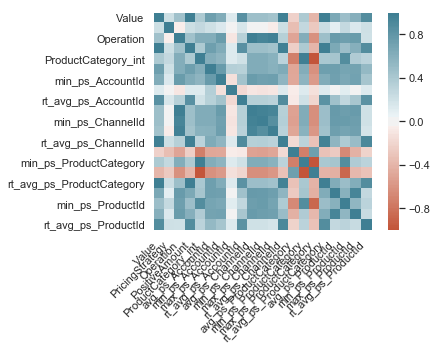

In [118]:
plot_heatmap(fraud_data.filter('FraudResult == 0').select(numerical_features).toPandas(), 'spearman')
corr

,Value,PricingStrategy,Operation,PositiveAmount,ProductCategory_int,avg_ps_AccountId,min_ps_AccountId,max_ps_AccountId,rt_avg_ps_AccountId,avg_ps_ChannelId,...,max_ps_ChannelId,rt_avg_ps_ChannelId,avg_ps_ProductCategory,min_ps_ProductCategory,max_ps_ProductCategory,rt_avg_ps_ProductCategory,avg_ps_ProductId,min_ps_ProductId,max_ps_ProductId,rt_avg_ps_ProductId
Value,1.000000,0.017029,5.896341e-02,0.999963,5.178375e-02,5.100844e-01,3.018056e-01,2.739691e-01,3.221125e-01,6.919767e-02,...,4.895213e-02,9.712164e-01,1.237937e-01,4.885120e-02,-4.935073e-02,9.833024e-01,2.260633e-01,1.046484e-01,1.253440e-01,7.556298e-01
PricingStrategy,0.017029,1.000000,-2.591971e-02,0.017595,1.916159e-01,7.282277e-02,-3.783297e-03,3.369737e-01,-1.026433e-02,-2.203710e-02,...,-4.865522e-02,9.704142e-02,-3.875407e-02,-1.489399e-02,-1.047817e-01,3.267350e-02,-3.889148e-02,1.140754e-02,1.101868e-01,1.033286e-01
Operation,0.058963,-0.025920,1.000000e+00,0.058304,4.926526e-01,1.143432e-01,5.895137e-02,-9.076804e-02,-2.070810e-05,8.539959e-01,...,9.684338e-01,-4.654152e-15,4.624213e-02,8.817306e-02,-4.042106e-01,4.816444e-02,4.567852e-01,1.517963e-01,6.295757e-01,-1.002471e-01
PositiveAmount,0.999963,0.017595,5.830411e-02,1.000000,4.922096e-02,5.099122e-01,3.019177e-01,2.742619e-01,3.214540e-01,6.827212e-02,...,4.850219e-02,9.714740e-01,1.222281e-01,4.776942e-02,-4.552027e-02,9.839376e-01,2.243363e-01,1.023523e-01,1.262590e-01,7.560823e-01
ProductCategory_int,0.051784,0.191616,4.926526e-01,0.049221,1.000000e+00,1.081976e-01,4.336123e-02,9.941209e-02,-4.047703e-02,4.458695e-01,...,4.494075e-01,4.985542e-02,4.026975e-01,3.774698e-01,-9.168209e-01,1.045936e-15,2.194070e-01,3.855711e-01,5.145366e-02,-3.035512e-15
avg_ps_AccountId,0.510084,0.072823,1.143432e-01,0.509912,1.081976e-01,1.000000e+00,5.920974e-01,5.378610e-01,1.095532e-16,1.334625e-01,...,9.529714e-02,4.983234e-01,1.355224e-01,5.161190e-02,-8.474367e-02,4.877760e-01,2.699873e-01,1.035520e-01,2.087182e-01,3.623849e-01
min_ps_AccountId,0.301806,-0.003783,5.895137e-02,0.301918,4.336123e-02,5.920974e-01,1.000000e+00,3.113631e-02,-2.294172e-16,6.687425e-02,...,5.012462e-02,2.809188e-01,8.983397e-02,4.572866e-02,-3.038977e-02,2.859000e-01,1.115977e-01,4.525277e-02,6.197808e-02,1.803605e-01
max_ps_AccountId,0.273969,0.336974,-9.076804e-02,0.274262,9.941209e-02,5.378610e-01,3.113631e-02,1.000000e+00,9.501757e-16,-7.597215e-02,...,-8.383454e-02,3.587116e-01,-4.024268e-03,1.713879e-03,-5.648506e-02,2.836895e-01,9.085740e-02,3.339960e-02,1.898674e-01,2.920032e-01
rt_avg_ps_AccountId,0.322113,-0.010264,-2.070810e-05,0.321454,-4.047703e-02,1.095532e-16,-2.294172e-16,9.501757e-16,1.000000e+00,1.437107e-03,...,-6.191751e-04,3.379097e-01,9.340415e-02,4.438613e-02,4.525299e-04,3.098231e-01,1.871137e-01,5.728568e-02,7.236208e-02,4.695143e-01
avg_ps_ChannelId,0.069198,-0.022037,8.539959e-01,0.068272,4.458695e-01,1.334625e-01,6.687425e-02,-7.597215e-02,1.437107e-03,1.000000e+00,...,7.104246e-01,2.802841e-15,7.529176e-02,8.368698e-02,-3.732565e-01,4.963510e-02,4.388960e-01,1.822307e-01,5.338186e-01,-8.057087e-02


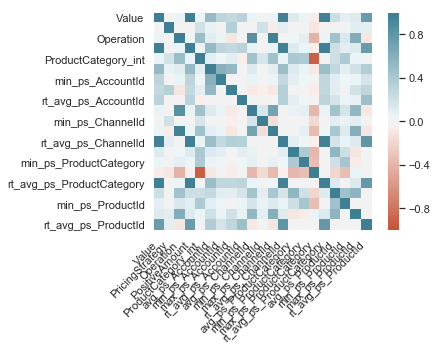

In [119]:
plot_heatmap(fraud_data.filter('FraudResult == 0').select(numerical_features).toPandas(), 'pearson')
corr

## Covariance

In [120]:
cov_ = []
def plot_heatmap_covariance(data):
  global cov_ 
  cov_ = data.cov()
  ax = sns.heatmap(
    cov_, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
  )
  ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

,Value,PricingStrategy,Operation,PositiveAmount,ProductCategory_int,avg_ps_AccountId,min_ps_AccountId,max_ps_AccountId,rt_avg_ps_AccountId,avg_ps_ChannelId,...,max_ps_ChannelId,rt_avg_ps_ChannelId,avg_ps_ProductCategory,min_ps_ProductCategory,max_ps_ProductCategory,rt_avg_ps_ProductCategory,avg_ps_ProductId,min_ps_ProductId,max_ps_ProductId,rt_avg_ps_ProductId
Value,4.532144e+12,-159330.929412,61206.509338,4.533909e+12,-283682.342401,2.949664e+11,2.939803e+11,3.960385e+11,2.485933e+06,-2.310141e+08,...,8.280266e+10,5.359294e+08,-1.011460e+09,-1.807336e+08,1.951233e+11,6.999113e+08,1.366172e+09,-2.894296e+08,3.179578e+11,1.996156e+08
PricingStrategy,-1.593309e+05,0.958626,-0.060470,-1.592191e+05,0.125443,-6.984091e+03,1.041702e+04,-1.147456e+05,1.164707e+01,-1.400585e+01,...,-5.579715e+04,-1.647305e+01,1.303715e+02,8.578834e+01,-3.742329e+04,-2.358040e+01,-1.476414e+03,1.376003e+02,-1.573196e+05,1.129142e+00
Operation,6.120651e+04,-0.060470,0.106888,6.110995e+04,-0.027142,6.985208e+03,2.526019e+03,1.809820e+04,2.889957e+00,2.693002e+02,...,7.237255e+04,3.511867e+00,1.084145e+02,1.618329e+01,6.682279e+03,8.720218e+00,9.115054e+02,6.523533e+00,5.941842e+04,-4.512727e-01
PositiveAmount,4.533909e+12,-159219.131238,61109.953162,4.535720e+12,-286675.583859,2.951255e+11,2.940380e+11,3.976886e+11,2.588122e+06,-2.305033e+08,...,8.265632e+10,5.361448e+08,-1.025336e+09,-1.810496e+08,1.984835e+11,7.002729e+08,1.362507e+09,-2.916374e+08,3.211911e+11,1.997060e+08
ProductCategory_int,-2.836823e+05,0.125443,-0.027142,-2.866756e+05,0.806942,-2.939178e+04,-1.081435e+04,-2.401768e+05,1.093120e+02,-1.903156e+02,...,-5.286255e+03,-3.224457e+01,7.157961e+03,1.970374e+03,-4.055966e+05,-6.064402e+01,3.908870e+03,2.104273e+03,-4.425673e+05,-1.139487e+01
avg_ps_AccountId,2.949664e+11,-6984.090661,6985.207864,2.951255e+11,-29391.783039,3.539895e+10,3.382024e+10,5.517648e+10,-9.081436e+06,-3.415001e+07,...,1.028578e+10,3.485209e+07,-1.736228e+08,-4.213449e+07,1.781633e+10,4.584884e+07,-8.038871e+06,-5.346948e+07,3.076885e+10,1.297453e+07
min_ps_AccountId,2.939803e+11,10417.020537,2526.018519,2.940380e+11,-10814.348982,3.382024e+10,3.809515e+10,-1.068854e+10,-2.884828e+06,-1.279990e+07,...,3.767947e+09,3.477661e+07,-5.791392e+07,-1.417342e+07,6.394152e+09,4.535700e+07,1.693730e+06,-1.888948e+07,1.104806e+10,1.316151e+07
max_ps_AccountId,3.960385e+11,-114745.622410,18098.198523,3.976886e+11,-240176.834805,5.517648e+10,-1.068854e+10,9.074429e+11,-6.804788e+07,-3.694938e+08,...,5.682148e+10,4.803411e+07,-1.550122e+09,-3.415247e+08,1.660226e+11,6.594366e+07,-4.200582e+08,-4.259633e+08,2.519651e+11,1.649328e+07
rt_avg_ps_AccountId,2.485933e+06,11.647073,2.889957,2.588122e+06,109.312019,-9.081436e+06,-2.884828e+06,-6.804788e+07,8.742027e+04,-1.150457e+04,...,3.973739e+06,2.772855e+02,1.440799e+06,4.551830e+05,-2.374225e+07,-3.659514e+03,1.290810e+06,4.485777e+05,-1.721971e+07,-1.226601e+03
avg_ps_ChannelId,-2.310141e+08,-14.005849,269.300158,-2.305033e+08,-190.315642,-3.415001e+07,-1.279990e+07,-3.694938e+08,-1.150457e+04,8.426789e+06,...,-6.495752e+08,-6.014325e+04,-3.608748e+05,-9.623180e+04,9.821104e+07,-3.521112e+04,8.037520e+06,-2.313329e+04,-3.703715e+08,-2.543432e+04


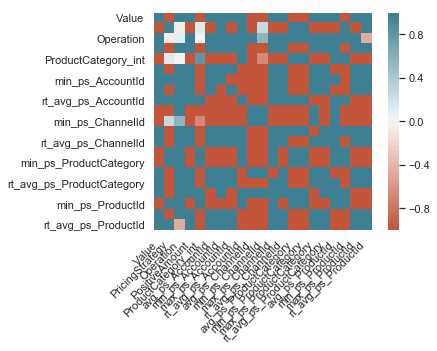

In [121]:
plot_heatmap_covariance( fraud_data.filter('FraudResult == 1').select(numerical_features).toPandas() )
cov_

## Outlier Analysis

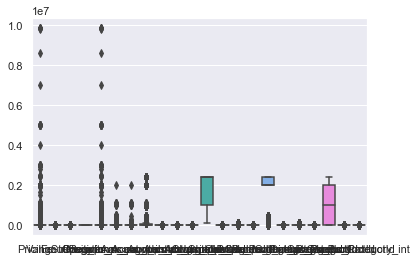

In [122]:
sns.boxplot(data=fraud_data.toPandas())

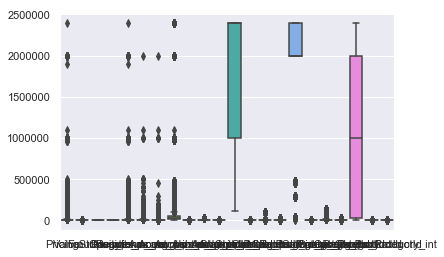

In [123]:
sns.boxplot(data=fraud_data.filter('FraudResult == 0').toPandas())

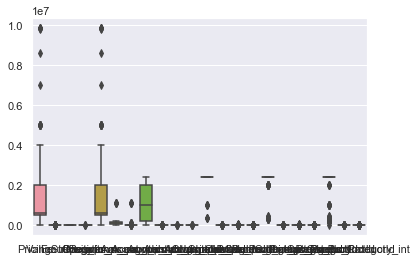

In [124]:
sns.boxplot(data=fraud_data.filter('FraudResult == 1').toPandas())

# Isolation Forest

In [125]:
def train_outlier_detection(fraud_data, numerical_features, label):
  fraud_data_pd_x = fraud_data.select(numerical_features).toPandas()
  fraud_data_pd_y = fraud_data.select(label).toPandas()

  X_train, X_test, y_train, y_test = train_test_split(fraud_data_pd_x, fraud_data_pd_y, test_size=0.3, random_state=42)
  return X_train, X_test, y_train, y_test

In [126]:
X_train, X_test, y_train, y_test = train_outlier_detection(fraud_data, numerical_features, label)
X_outliers = fraud_data.filter('FraudResult==1').select(numerical_features).toPandas()

## Isolation Forest Predictions and precision analysis

In [127]:
# Input:
# TP | FP
# FN | TN

# Output:
#   F1-score
def compute_f1score(data):
  tp = data[0][0]
  fp = data[0][1]
  fn = data[1][0]
  tn = data[1][1]
  # sensitivity, recall, hit rate, or true positive rate (TPR)
  tpr = tp / (tp+fn)
  # precision or positive predictive value (PPV)
  ppv = tp / (tp+fp)
  # F1 score is the harmonic mean of precision and sensitivity
  f1_score = 2 * (ppv*tpr) / (ppv+tpr)
  return f1_score

In [128]:
# Input: Positive=-1 and Negative=1
# Output: Positive=1 and Negative=0
def norm_pred(data):
  data = ((data*-1)+1)/2
  return data

def train_isolation_forest(X_train, X_test, y_train, y_test, X_outliers, max_sample_list, cont_list):
  # fit the model
  rng = np.random.RandomState(42)

  graph_performance = pd.DataFrame([], columns=['f1','max','cont'])

  for max_sample in max_sample_list:
    for cont in cont_list:

      clf = IsolationForest(behaviour='new', max_samples=max_sample,
                            random_state=rng, contamination=cont)

      clf.fit(X_train)

      y_pred_train = clf.predict(X_train)
      y_pred_test = clf.predict(X_test)
      y_pred_outliers = clf.predict(X_outliers)

      y_pred_test = norm_pred(y_pred_test)
      y_pred_outliers = norm_pred(y_pred_outliers)

      cm = confusion_matrix(y_test, y_pred_test)
      f1_score = compute_f1score(cm)
  
      new_row = pd.DataFrame({'f1':[f1_score], 'max':[max_sample], 'cont':[cont]})
      graph_performance = graph_performance.append(new_row)
  return graph_performance, clf

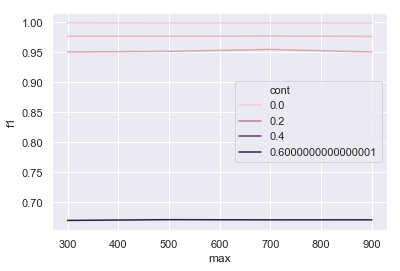

In [129]:
max_sample_list = [300, 500, 700, 900]
cont_list = [0.003, 0.05, 0.1, 0.5]

graph_perf, clf_imbalanced = train_isolation_forest(X_train, X_test, y_train, y_test, X_outliers, max_sample_list, cont_list)

sns.set(style='darkgrid')
sns.lineplot(x='max', y='f1', hue='cont',  data=graph_perf)

In [130]:
graph_perf[graph_perf.f1 == graph_perf.f1.max()]

,f1,max,cont
0,0.999075,300,0.003


## Data Imbalance

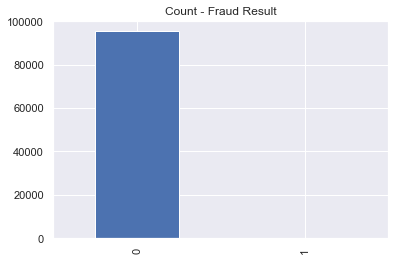

In [131]:
pd.Series((fraud_data.toPandas())[label]).value_counts().plot.bar(title='Count - Fraud Result')

# Balance Data

## SMOTENC

In [181]:
def balance_pyspark_dataframe(data, features, label, categorical_pos):
  sm = SMOTENC(categorical_features=categorical_pos, random_state = 42)
  data_pd = data.toPandas()
  X_train_new, y_train_new = sm.fit_sample(data_pd[features], data_pd[label].ravel())
  X_train_new = pd.DataFrame(X_train_new, columns=all_features)
  y_train_new = pd.DataFrame(y_train_new, columns=[label])
  return X_train_new, y_train_new

In [183]:
cat_features = [0, 1, 2, 3, 4, 5, 6]
fraud_data_smotenc_x, fraud_data_smotenc_y = balance_pyspark_dataframe(fraud_data, all_features, label, cat_features)
#fraud_data_balanced_x.to_csv('/content/fraud_data_balanced_smotenc_x.csv', index=False)
#fraud_data_balanced_y.to_csv('/content/fraud_data_balanced_smotenc_y.csv', index=False)

In [185]:
fraud_data_smotenc_x.head()

,ProductId,ProductCategory,PricingStrategy,ChannelId,ProviderId,AccountId,TransactionId,Value,Operation,PositiveAmount,...,max_ps_ChannelId,rt_avg_ps_ChannelId,avg_ps_ProductCategory,min_ps_ProductCategory,max_ps_ProductCategory,rt_avg_ps_ProductCategory,avg_ps_ProductId,min_ps_ProductId,max_ps_ProductId,rt_avg_ps_ProductId
0,ProductId_10,airtime,2,ChannelId_3,ProviderId_6,AccountId_3957,TransactionId_76871,1000,1,1000,...,2.4e+06,-0.88163,5867.8,33,2e+06,-0.829578,7447.45,300,2e+06,-0.865726
1,ProductId_6,financial_services,2,ChannelId_2,ProviderId_4,AccountId_4841,TransactionId_73770,20,-1,20,...,1e+06,-0.994786,6504.7,1.2,2.4e+06,-0.996925,903.643,1.2,25000,-0.977867
2,ProductId_1,airtime,2,ChannelId_3,ProviderId_6,AccountId_4229,TransactionId_26203,500,1,500,...,2.4e+06,-0.940815,5867.8,33,2e+06,-0.914789,4202.86,33,300000,-0.881033
3,ProductId_21,utility_bill,2,ChannelId_3,ProviderId_1,AccountId_648,TransactionId_380,21800,1,20000,...,2.4e+06,1.36741,15820.9,500,300000,0.264147,12787.2,500,190000,0.564068
4,ProductId_6,financial_services,2,ChannelId_2,ProviderId_4,AccountId_4841,TransactionId_28195,644,-1,644,...,1e+06,-0.832112,6504.7,1.2,2.4e+06,-0.900995,903.643,1.2,25000,-0.287329


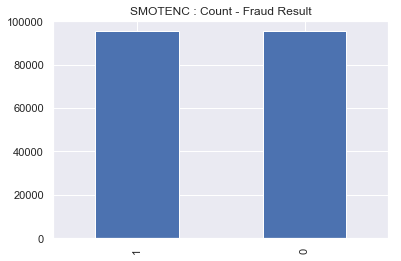

In [187]:
pd.Series(fraud_data_smotenc_y[label]).value_counts().plot.bar(title='SMOTENC : Count - Fraud Result')

## SMOTE

In [ ]:
X_smote = fraud_data.select(numerical_features).toPandas()
y_smote = fraud_data.select(label).toPandas()

smote_over_sampler = SMOTE(random_state=42)
fraud_data_smote_x, fraud_data_smote_y = smote_over_sampler.fit_resample(X_smote, y_smote)

In [ ]:
pd.Series(fraud_data_smote_y).value_counts().plot.bar(title='SMOTE : Count - Fraud Result')

## RandomOverSampling

In [ ]:
X = fraud_data.select(all_features).toPandas()
y = fraud_data.select(label).toPandas()

ros = RandomOverSampler(random_state=42)
fraud_data_ros_x, fraud_data_ros_y = ros.fit_resample(X, y)

In [ ]:
pd.Series(fraud_data_ros_y).value_counts().plot.bar(title='RANDOM_OVER : Count - Fraud Result')

## ADASYN

In [ ]:
X_adasyn = fraud_data.select(numerical_features).toPandas()
y_adasyn = fraud_data.select(label).toPandas()

adasyn_over_sampler = ADASYN(random_state=42)
fraud_data_adasyn_x, fraud_data_adasyn_y = adasyn_over_sampler.fit_resample(X_adasyn, y_adasyn)

In [ ]:
pd.Series(fraud_data_adasyn_y).value_counts().plot.bar(title='ADASYN : Count - Fraud Result')

---

In [ ]:
print(type(fraud_data_smotenc_x))
print(type(fraud_data_ros_x))
print(type(fraud_data_smote_x))
print(type(fraud_data_adasyn_x))

---

## Isolation Forest Evaluation of Oversampling

In [ ]:
sns.set(style='darkgrid')

### SMOTENC

In [ ]:
max_sample_list_smotenc = [300, 500, 700, 900]
cont_list_smotenc = [0.003, 0.05, 0.1, 0.5]
X_train, X_test, y_train, y_test = train_test_split(fraud_data_smotenc_x[numerical_features], fraud_data_smotenc_y, test_size=0.3, random_state=42)
X_outliers = fraud_data_smotenc_x[fraud_data_smotenc_y['FraudResult']==1][numerical_features]
graph_perf_smotenc, clf = train_isolation_forest(X_train, X_test, y_train, y_test, X_outliers, max_sample_list_smotenc, cont_list_smotenc)

sns.lineplot(x='max', y='f1', hue='cont',  data=graph_perf_smotenc)

In [ ]:
graph_perf_smotenc[graph_perf_smotenc.f1 == graph_perf_smotenc.f1.max()]

### SMOTE

In [ ]:
max_sample_list_smote = [300, 500, 700, 900]
cont_list_smote = [0.003, 0.05, 0.1, 0.5]
X_train, X_test, y_train, y_test = train_test_split(fraud_data_smote_x, fraud_data_smote_y, test_size=0.3, random_state=42)
X_outliers = fraud_data_smote_x[fraud_data_smote_y==1]
graph_perf_smote, clf = train_isolation_forest(X_train, X_test, y_train, y_test, X_outliers, max_sample_list_smote, cont_list_smote)

sns.lineplot(x='max', y='f1', hue='cont',  data=graph_perf_smote)

In [ ]:
graph_perf_smote[graph_perf_smote.f1 == graph_perf_smote.f1.max()]

### RandomOverSampling

In [ ]:
max_sample_list_ros = [300, 500, 700, 900]
cont_list_ros = [0.003, 0.05, 0.1, 0.5]
X_train, X_test, y_train, y_test = train_test_split(fraud_data_ros_x[:,3:], fraud_data_ros_y, test_size=0.3, random_state=42)
X_outliers = fraud_data_ros_x[fraud_data_ros_y == 1][:,3:]
graph_perf_ros, clf = train_isolation_forest(X_train, X_test, y_train, y_test, X_outliers, max_sample_list_ros, cont_list_ros)

sns.lineplot(x='max', y='f1', hue='cont',  data=graph_perf_ros)

In [ ]:
graph_perf_ros[graph_perf_ros.f1 == graph_perf_ros.f1.max()]

### ADASYN

In [ ]:
max_sample_list_adasyn = [300, 500, 700, 900]
cont_list_adasyn = [0.003, 0.05, 0.1, 0.5]
X_train, X_test, y_train, y_test = train_test_split(fraud_data_adasyn_x, fraud_data_adasyn_y, test_size=0.3, random_state=42)
X_outliers = fraud_data_adasyn_x[fraud_data_adasyn_y==1]
graph_perf_adasyn, clf = train_isolation_forest(X_train, X_test, y_train, y_test, X_outliers, max_sample_list_adasyn, cont_list_adasyn)

sns.lineplot(x='max', y='f1', hue='cont',  data=graph_perf_adasyn)

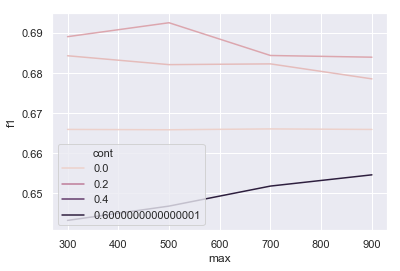

In [ ]:
graph_perf_adasyn[graph_perf_adasyn.f1 == graph_perf_adasyn.f1.max()]

## Add outlier feature estimation

In [ ]:
predictions = clf.predict(fraud_data_smotenc_x[numerical_features])
fraud_data_smotenc_x['IsolationForest'] = predictions

# Learning Curve

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    '''
    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    '''
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
X, y = fraud_data_smotenc_x[numerical_features], fraud_data_smotenc_y

cv_smotenc = ShuffleSplit(n_splits=100, test_size=0.25, random_state=42)

In [ ]:
title = "Learning Curve - GAUSSIAN"
estimator = GaussianNB()
# n-jobs: quantidade de processadores executando
# (0.953, 0.975): margen do eixo y
plot_learning_curve(estimator, title, X, y, (0.953, 0.975), cv=cv_smotenc, n_jobs=10)
plt.show()

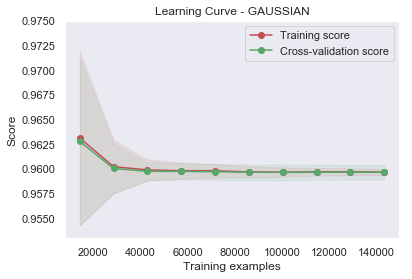

In [ ]:
title = r"Learning Curves - SGDClassifier"
estimator = SGDClassifier()
# n-jobs: quantidade de processadores executando
# (0.94, 1.01): margen do eixo y
plot_learning_curve(estimator, title, X, y, (0.94, 1.01), cv=cv_smotenc, n_jobs=10)
plt.show()

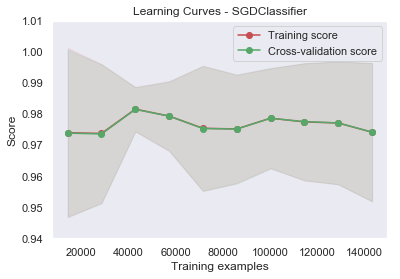

# Catboost Model

In [ ]:
cv_dataset = Pool(data=fraud_data_smotenc_x,
                                  label=fraud_data_smotenc_y,
                                  cat_features=cat_features)

iterations = 200
max_depth = 5
num_folds = 8

params = {"iterations": iterations,
          "depth": max_depth,
          "loss_function": "Logloss",
          "verbose": False,
          "roc_file": "roc-file"}

scores = cv(cv_dataset,
            params,
            fold_count=num_folds, 
            plot="True")

In [ ]:
model = CatBoostClassifier(max_depth=max_depth, 
                                                   verbose=False, 
                                                   max_ctr_complexity=1, 
                                                   iterations=iterations).fit(cv_dataset)
model.fit(cv_dataset)

In [ ]:
print("Count of trees in model = {}".format(model.tree_count_))

In [ ]:
model.plot_tree(tree_idx=0, pool=cv_dataset)

## AUC and ROC curves

In [ ]:
data = pd.read_csv('/content/catboost_info/roc-file', sep='\t')
x = data['FPR']
y = data['TPR']
# This is the ROC curve
plt.plot(x,y)
plt.show() 

# This is the AUC
auc = np.trapz(y,x)
print('The AUC was: {0:.2f}.'.format(auc))

## Feature Importance

In [ ]:
model = CatBoostClassifier(iterations=50, learning_rate=0.1, random_seed=42)
model.fit(fraud_data_smotenc_x, fraud_data_smotenc_y, verbose=False, plot=False, cat_features=cat_features)

In [ ]:
shap.initjs()

shap_values = model.get_feature_importance(Pool(fraud_data_smotenc_x, fraud_data_smotenc_y, cat_features=cat_features), type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

# visualize the first prediction's explanation
shap.force_plot(expected_value, shap_values[200,:], fraud_data_balanced_x.iloc[200,:])

In [ ]:
shap.initjs()
# visualize the training set predictions
shap.force_plot(expected_value, shap_values, fraud_data_balanced_x)

In [ ]:
shap.initjs()
# summarize the effects of all the features
shap.summary_plot(shap_values, fraud_data_smotenc_x)

# Evaluation

In [ ]:
test_data = read_data_from_web("https://drive.google.com/uc?export=download&id=16cRQIFW6n2th2YOK7DEsp9dQgihHDuHa")
test_data = test_data.withColumn('PositiveAmount', F.abs(test_data['Amount']))
test_data = test_data.withColumn("Operation", F.when(test_data.Amount > 0, 1).when(test_data.Amount < 0, -1).otherwise(0))
columns_to_remove = ['Amount','CurrencyCode','CountryCode','BatchId','AccountId','SubscriptionId','CustomerId', 'ProviderId', 'TransactionStartTime']
test_data = remove_feature(test_data, columns_to_remove)

gen_train_data = fraud_data.filter('FraudResult == 0')
items_list = ['ChannelId', 'ProductCategory', 'ProductId']

for item in items_list:
  mean_column_name = 'avg_ps_{0}'.format(item)
  ratio_column_name = 'rt_avg_ps_{0}'.format(item)
  aux = gen_train_data.select([item,'PositiveAmount']).groupBy(item).mean()
  aux = aux.select(col(item), col('avg(PositiveAmount)').alias(mean_column_name))
  test_data = test_data.join(aux, on=item)
  test_data = test_data.withColumn(ratio_column_name, (F.col('PositiveAmount')-F.col(mean_column_name))/ F.col(mean_column_name))
 
test_data = test_data.toPandas()
predictions = clf.predict(test_data[numerical_features])
test_data['IsolationForest'] = predictions

In [ ]:
pred = Pool(data=test_data[all_features], cat_features=cat_features)
test_pred = model.predict(pred, prediction_type='Class')

In [ ]:
test_data = read_data_from_web("https://drive.google.com/uc?export=download&id=16cRQIFW6n2th2YOK7DEsp9dQgihHDuHa")

def save_predictions_xente(file_name, transactions_list, predictions_list):
  file = open(file_name,'w')
  file.write('TransactionId,FraudResult\n')
  for trans_id, value in zip(transactions_list, test_pred):
    file.write('{0},{1}\n'.format(trans_id, int(value)))
  for item in (set(transactions_list)-id_list):
    file.write('{0},0\n'.format(item))
  file.close()
  
file_name = '/content/xento_predictions_2.csv'  
transactions_list = test_data['TransactionId']

save_predictions_xente(file_name, transactions_list, test_pred)